
# Transfer Learning


In [9]:
import torch
import torchvision
from torchvision.transforms import v2

import torchinfo

import matplotlib.pyplot as plt
import numpy as np
import time

# importing a module with utilities for displaying stats and data
import sys
sys.path.insert(1, '../../util')
import vcpi_util


from tqdm import tqdm

In [10]:
def train(model, train_loader, val_loader, epochs, loss_fn, optimizer, scheduler, early_stopper, save_prefix = 'model'):

    history = {}
    history['accuracy'] = []
    history['val_acc'] = []
    history['val_loss'] = []
    history['loss'] = []
    best_val_loss = np.inf

    for epoch in range(epochs):  # loop over the dataset multiple times

        model.train()
        start_time = time.time() 
        correct = 0
        running_loss = 0.0
        for i, (inputs, targets) in tqdm(enumerate(train_loader, 0)):
            
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            loss = loss_fn(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.cpu().detach().numpy()
            correct += (predicted == targets).sum().cpu().detach().numpy()

        model.eval()
        v_correct = 0
        val_loss = 0.0
        with torch.no_grad():
            for i,t in val_loader:
                i = i.to(device)
                t = t.to(device)
                o = model(i)
                _,p = torch.max(o,1)
                
                #with torch.no_grad():
                val_loss += loss_fn(o, t).cpu().detach().numpy()

                v_correct += (p == t).sum().cpu().detach().numpy()

        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        
        if old_lr != new_lr:
            print('==> Learning rate updated: ', old_lr, ' -> ', new_lr)

        epoch_loss = running_loss / len(train_loader.dataset)
        accuracy = 100 * correct / len(train_loader.dataset)
        v_accuracy = 100 * v_correct / len(val_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        stop_time = time.time()
        print(f'Epoch: {epoch:03d}; Loss: {epoch_loss:0.6f}; Accuracy: {accuracy:0.4f}; Val Loss: {val_loss:0.6f}; Val Acc: {v_accuracy:0.4f}; Elapsed time: {(stop_time - start_time):0.4f}')
        history['accuracy'].append(accuracy)
        history['val_acc'].append(v_accuracy)
        history['val_loss'].append(val_loss)
        history['loss'].append(epoch_loss)
 
        ###### Saving ######
        if val_loss < best_val_loss:
           
            torch.save({
                'epoch': epoch,
                'model':model.state_dict(),
                'history': history,
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
                },
                f'{save_prefix}_best.pt')

        if early_stopper(val_loss):
            print('Early stopping!')
            break
        
    print('Finished Training')

    return(history)


def evaluate(model, data_loader):

    # sets the model in evaluation mode.
    # although our model does not have layers which behave differently during training and evaluation
    # this is a good practice as the models architecture may change in the future
    model.eval()

    correct = 0
    
    for i, (images, targets) in enumerate(data_loader):
         
        # forward pass, compute the output of the model for the current batch
        outputs = model(images.to(device))

        # "max" returns a namedtuple (values, indices) where values is the maximum 
        # value of each row of the input tensor in the given dimension dim; 
        # indices is the index location of each maximum value found (argmax).
        # the argmax effectively provides the predicted class number        
        _, preds = torch.max(outputs, dim=1)

        correct += (preds.cpu() == targets).sum()

    return (correct / len(data_loader.dataset)).item()


class Early_Stopping():

    def __init__(self, patience = 3, min_delta = 0.00001):

        self.patience = patience 
        self.min_delta = min_delta

        self.min_delta
        self.min_val_loss = float('inf')

    def __call__(self, val_loss):

        # improvement
        if val_loss + self.min_delta < self.min_val_loss:
            self.min_val_loss = val_loss
            self.counter = 0

        # no improvement            
        else:
            self.counter += 1
            if self.counter > self.patience:
                return True
            
        return False
    


def build_confusion_matrix(model, dataset):

    preds = []
    ground_truth = []

    for images, targets in dataset:

        predictions = model(images.to(device))
        preds_sparse = [np.argmax(x) for x in predictions.cpu().detach().numpy()]
        preds.extend(preds_sparse)
        ground_truth.extend(targets.numpy())

    vcpi_util.show_confusion_matrix(ground_truth, preds, len(test_set.classes))      


## Settings

In [56]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

BATCH_SIZE = 32

IMG_SIZE = 128

EPOCHS = 30

SAMPLES = 23000

prefix = 'h:/vcpi/dogsVScats'

PATH_TEST_SET = f'{prefix}/test'
PATH_VAL_SET =f'{prefix}/val{SAMPLES}'

PATH_TRAINING_SET = f'{prefix}/train{SAMPLES}'

cuda:0


## The dataset: Dogs Vs Cats

Original data set can be found in: https://www.kaggle.com/c/dogs-vs-cats/data

![image](notebook_images/dogs_vs_cats.png)

The dataset consists of 25000 thousand images from cats and dogs. 2000 images were randomly collected for the test set. From the remaining 23000 images, 20% were used for the validation set.



In [57]:
from torchvision.transforms import v2

train_transform = v2.Compose([
        v2.Resize((IMG_SIZE,IMG_SIZE)),
        v2.RandomHorizontalFlip(),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transform = v2.Compose([
        v2.Resize((IMG_SIZE,IMG_SIZE)),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_set = torchvision.datasets.ImageFolder(root=PATH_TRAINING_SET, transform = train_transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = BATCH_SIZE, shuffle=True)

# No shuffle is required for the test set, also the batch size can be completely different
test_set = torchvision.datasets.ImageFolder(root=PATH_TEST_SET, transform = train_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = BATCH_SIZE)

val_set = torchvision.datasets.ImageFolder(root=PATH_VAL_SET, transform = test_transform)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = BATCH_SIZE)


In [13]:
images, targets = next(iter(train_loader))
print("Batch shape: ", images.shape)


Batch shape:  torch.Size([16, 3, 128, 128])


Displaying some images after the transform has been applied.

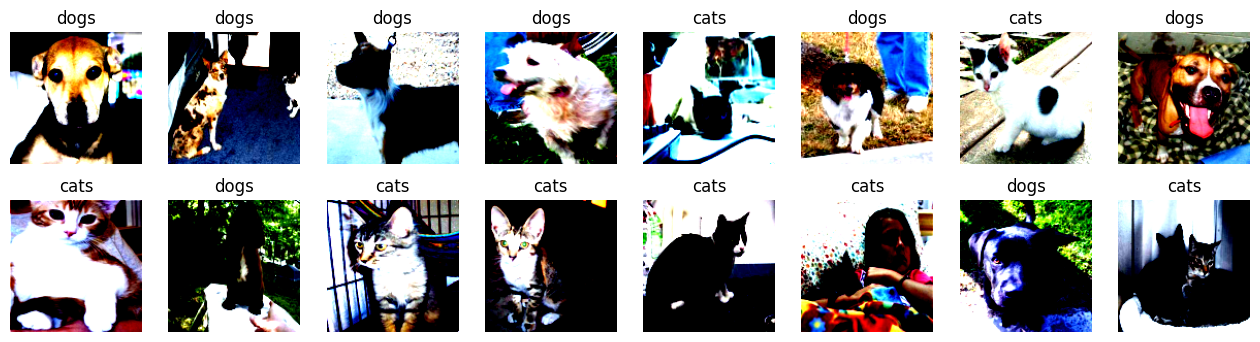

<Figure size 640x480 with 0 Axes>

In [14]:
vcpi_util.show_images(2,8, images, targets, train_set.classes) 

## Explore torchvision models

Pytorch info on models and pretrained weights: https://pytorch.org/vision/stable/models.html

### Listing all models available in torchvision

In [23]:
model_names = torchvision.models.list_models(module=torchvision.models)
print(model_names)

['alexnet', 'convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m', 'efficientnet_v2_s', 'googlenet', 'inception_v3', 'maxvit_t', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'regnet_x_16gf', 'regnet_x_1_6gf', 'regnet_x_32gf', 'regnet_x_3_2gf', 'regnet_x_400mf', 'regnet_x_800mf', 'regnet_x_8gf', 'regnet_y_128gf', 'regnet_y_16gf', 'regnet_y_1_6gf', 'regnet_y_32gf', 'regnet_y_3_2gf', 'regnet_y_400mf', 'regnet_y_800mf', 'regnet_y_8gf', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'resnext101_32x8d', 'resnext101_64x4d', 'resnext50_32x4d', 'shufflenet_v2_x0_5', 'shufflenet_v2_x1_0', 'shufflenet_v2_x1_5', 'shufflenet_v2_x2_0', 'squeezenet1_0

Most models are composed by blocks. From a very high level point of view (and somewhat simplified view) one can see the initial blocks as feature extractors, they gather information about the input image. This information is passed from layer to layer until it reaches the last block. This last block is then responsible for the classification.


To reuse such a model we keep the feature extraction blocks and replace the head of the model.

In [24]:
# Example: loading a model with pre-trained weights
model = torchvision.models.efficientnet_b0(weights = torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1)
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## VGG 16

VGG16 was proposed in [“Very Deep Convolutional Networks For Large-Scale Image Recognition”](https://arxiv.org/pdf/1409.1556.pdf)

In [25]:

# load model from torchs repo
model = torchvision.models.vgg16()
model.to(device)

n_inputs = model.classifier[0].in_features

model.classifier = torch.nn.Sequential(
    torch.nn.Linear(n_inputs, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 2)
)
model.to(device)
print(model)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [26]:
torchinfo.summary(model, input_size=(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [32, 2]                   --
├─Sequential: 1-1                        [32, 512, 4, 4]           --
│    └─Conv2d: 2-1                       [32, 64, 128, 128]        1,792
│    └─ReLU: 2-2                         [32, 64, 128, 128]        --
│    └─Conv2d: 2-3                       [32, 64, 128, 128]        36,928
│    └─ReLU: 2-4                         [32, 64, 128, 128]        --
│    └─MaxPool2d: 2-5                    [32, 64, 64, 64]          --
│    └─Conv2d: 2-6                       [32, 128, 64, 64]         73,856
│    └─ReLU: 2-7                         [32, 128, 64, 64]         --
│    └─Conv2d: 2-8                       [32, 128, 64, 64]         147,584
│    └─ReLU: 2-9                         [32, 128, 64, 64]         --
│    └─MaxPool2d: 2-10                   [32, 128, 32, 32]         --
│    └─Conv2d: 2-11                      [32, 256, 32, 32]         29

## Training from scratch

In [27]:
loss_fn = torch.nn.CrossEntropyLoss()

early_stop = Early_Stopping(9, min_delta = 0.000001)
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = 0.1, patience=3)    

#history = train(model, train_loader, val_loader, 3, loss_fn, optimizer, scheduler, early_stop, f'model')

In [28]:
evaluate(model, test_loader)

0.49900001287460327

The model does not seem capable of learning, reporting an accuracy of 50%. Lets check some misclassified images.

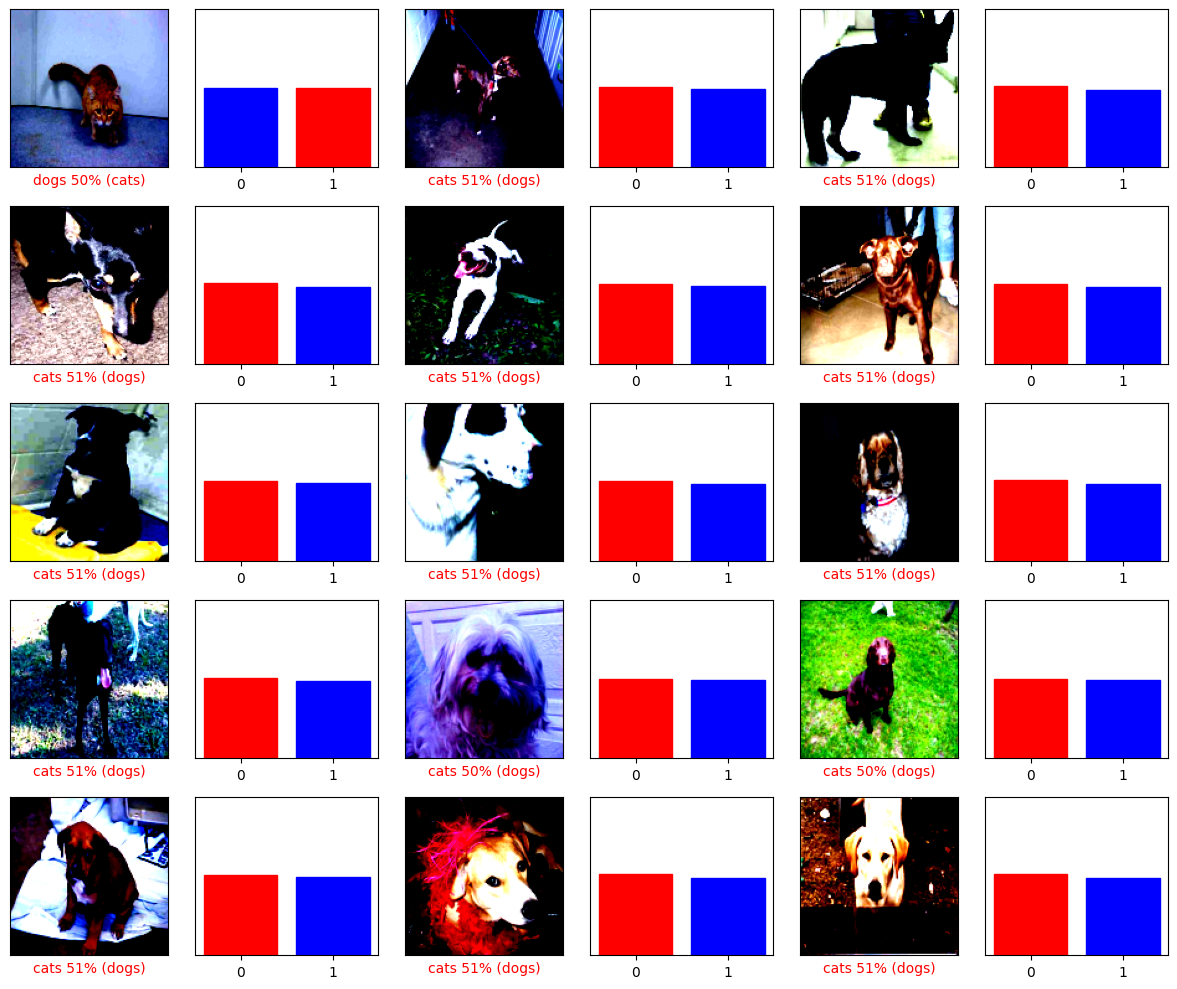

In [39]:
vcpi_util.show_misclassified(5,3,3,(128,128), test_loader, model, device)

## Transfer Learning

The goal is to use the knowledge from a previously trained model as a starting point to train a model in a new dataset.

Transfer learning takes advantage on the fact that all the feature extraction has already been learned, so a small tunning of the model should allow for faster training and a more performant model.

Most available models are composed by blocks. From a very high level point of view (and somewhat simplified view) one can see the initial blocks as feature extractors, they gather information about the input image. This information is passed from layer to layer until it reaches the last block. This last block is then responsible for the classification.

These models have been trained on the ImageNet-1K dataset, and these weights are also available from torchvision. See torch [documentation](https://pytorch.org/vision/stable/models.html#table-of-all-available-classification-weights) page for a full list.

Transfer Learning can be performed in two phases:

- Initially freeze all the weights for all the blocks, except the classifier block. This will only train the classifier weights.
- Gradually unfreeze the frozen blocks, retraining the model progressively.


In [40]:
# Example: loading a model with pre-trained weights
model = torchvision.models.efficientnet_b0(weights = torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1)
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### Training

In here we are going to use VGG-16 with:

- use the pretrained weights
- freeze all the weights
- replace the original classifier 

In [58]:
# load model from torchs repo, with pretrained weights from ImageNet
model = torchvision.models.vgg16(weights = torchvision.models.VGG16_Weights.IMAGENET1K_V1)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

print()

n_inputs = model.classifier[0].in_features

model.classifier = torch.nn.Sequential(
    torch.nn.Linear(n_inputs, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 2)
)
model.to(device)
print(model)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [59]:
loss_fn = torch.nn.CrossEntropyLoss()

early_stop = Early_Stopping(9, min_delta = 0.000001)
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = 0.1, patience=3)    

history = train(model, train_loader, val_loader, EPOCHS, loss_fn, optimizer, scheduler, early_stop, f'model_{SAMPLES}')

705it [01:08, 10.27it/s]


Epoch: 000; Loss: 0.003202; Accuracy: 96.5750; Val Loss: 0.002414; Val Acc: 97.6087; Elapsed time: 70.0245


705it [01:11,  9.85it/s]


Epoch: 001; Loss: 0.001916; Accuracy: 97.6575; Val Loss: 0.002302; Val Acc: 97.1739; Elapsed time: 73.6364


705it [01:11,  9.90it/s]


Epoch: 002; Loss: 0.001585; Accuracy: 98.0701; Val Loss: 0.002257; Val Acc: 96.7391; Elapsed time: 72.6760


705it [01:08, 10.29it/s]


Epoch: 003; Loss: 0.001343; Accuracy: 98.4161; Val Loss: 0.002232; Val Acc: 97.3913; Elapsed time: 69.7903


705it [01:11,  9.83it/s]


Epoch: 004; Loss: 0.001067; Accuracy: 98.7356; Val Loss: 0.003720; Val Acc: 96.7391; Elapsed time: 73.0786


705it [01:07, 10.47it/s]


Epoch: 005; Loss: 0.000956; Accuracy: 98.8820; Val Loss: 0.004065; Val Acc: 96.5217; Elapsed time: 68.7160


705it [01:07, 10.38it/s]


Epoch: 006; Loss: 0.000854; Accuracy: 99.0550; Val Loss: 0.004323; Val Acc: 95.8696; Elapsed time: 69.3695


705it [01:07, 10.42it/s]


==> Learning rate updated:  0.001  ->  0.0001
Epoch: 007; Loss: 0.000717; Accuracy: 99.1925; Val Loss: 0.004484; Val Acc: 96.5217; Elapsed time: 69.0669


705it [01:08, 10.24it/s]


Epoch: 008; Loss: 0.000398; Accuracy: 99.5075; Val Loss: 0.003103; Val Acc: 97.3913; Elapsed time: 70.3578


705it [01:09, 10.20it/s]


Epoch: 009; Loss: 0.000280; Accuracy: 99.6584; Val Loss: 0.003185; Val Acc: 97.3913; Elapsed time: 70.5803


705it [01:10,  9.95it/s]


Epoch: 010; Loss: 0.000198; Accuracy: 99.7826; Val Loss: 0.003658; Val Acc: 97.3913; Elapsed time: 72.1976


705it [01:10, 10.01it/s]


==> Learning rate updated:  0.0001  ->  1e-05
Epoch: 011; Loss: 0.000166; Accuracy: 99.8092; Val Loss: 0.003918; Val Acc: 97.3913; Elapsed time: 71.9275


705it [01:10,  9.95it/s]


Epoch: 012; Loss: 0.000124; Accuracy: 99.8713; Val Loss: 0.003869; Val Acc: 97.3913; Elapsed time: 72.2421


705it [01:10,  9.98it/s]


Epoch: 013; Loss: 0.000124; Accuracy: 99.8713; Val Loss: 0.003840; Val Acc: 97.3913; Elapsed time: 72.1897
Early stopping!
Finished Training


In [61]:
reload = torch.load(f'model_23000_best_.pt')
print(reload['epoch'])
model.load_state_dict(reload['model'])
evaluate(model, test_loader)

13


0.9764999747276306

In [62]:
evaluate(model, test_loader)

0.9745000004768372

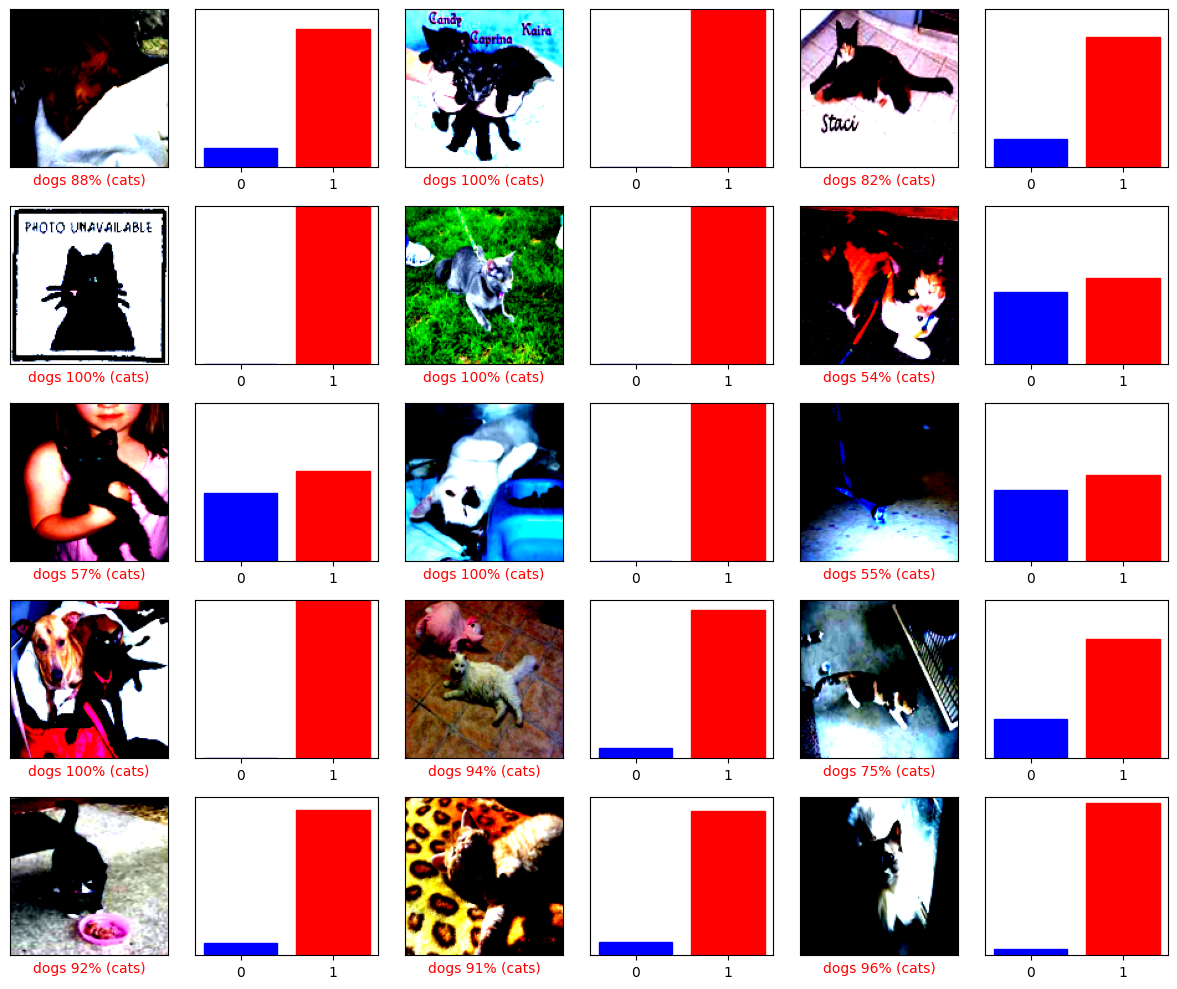

In [63]:
vcpi_util.show_misclassified(5,3,3,(128,128), test_loader, model, device)